In [3]:
import pandas as pd
import numpy as np
from convlstm import ConvLSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
from skimage import io
from sklearn.model_selection import train_test_split



In [4]:
data_image = pd.read_csv("dataset/3_cam_dataset/dynamic01/cmd_vel1.csv",usecols=['rosbagTimestamp','x','z'])
data_image = data_image.to_numpy()
data_image.shape


print (data_image.shape)        



(3638, 3)


In [5]:
class RGBDataset():
    """Face Landmarks dataset."""
        
    def __init__(self, nb_frames,root_dir1,root_dir2,root_dir3):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv("dataset/3_cam_dataset/dynamic01/cmd_vel1.csv",usecols=['rosbagTimestamp','x','z']).to_numpy()
        self.data_train,_ = train_test_split(self.data,test_size = 0.1, shuffle=False)
        self.nb_frames = nb_frames
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.root_dir3 = root_dir3


    def __len__(self):
        return len(self.data_train) -10
        #return len(self.data_train) - (self.nb_frames)
        #return 200
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        X_train_t1 = [io.imread(os.path.join(self.root_dir1,str(int(self.data_train[idx+i,0]))+'.jpeg')).astype(np.float32) for i in [0,1,2,3,4,5]]
        X_train_t2 = [io.imread(os.path.join(self.root_dir2,str(int(self.data_train[idx+i,0]))+'.jpeg')).astype(np.float32) for i in [0,1,2,3,4,5]] 
        X_train_t3 = [io.imread(os.path.join(self.root_dir3,str(int(self.data_train[idx+i,0]))+'.jpeg')).astype(np.float32) for i in [0,1,2,3,4,5]] 
        X_train_t1 = np.stack(X_train_t1, axis=0)
        X_train_t2 = np.stack(X_train_t2, axis=0) 
        X_train_t3 = np.stack(X_train_t3, axis=0) 
        X_train = np.concatenate((X_train_t3,X_train_t2,X_train_t1),axis =2)
        
        
        X_train1 = np.moveaxis(X_train,-1,1)
        
        y_train_t = [self.data_train[idx+i,1:3].astype(np.float32) for i in [5,6,7,8,9]]
        y_train = np.stack(y_train_t, axis=0)
        y_train1 = y_train.reshape(5,2)
        
        sample = {'X_train': X_train1, 'y_train': y_train1}

        return sample

In [6]:
class RGBDataset_test():
    """Face Landmarks dataset."""
        
    def __init__(self, nb_frames,root_dir1,root_dir2,root_dir3):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv("dataset/3_cam_dataset/dynamic01/cmd_vel1.csv",usecols=['rosbagTimestamp','x','z']).to_numpy()
        self.data_train,self.data_test= train_test_split(self.data,test_size = 0.1, shuffle=False)
        self.nb_frames = nb_frames
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.root_dir3 = root_dir3


    def __len__(self):
        return len(self.data_test) - 10
        #return 200
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        X_train_t1 = [io.imread(os.path.join(self.root_dir1,str(int(self.data_train[idx+i,0]))+'.jpeg')).astype(np.float32) for i in [0,1,2,3,4,5]]
        X_train_t2 = [io.imread(os.path.join(self.root_dir2,str(int(self.data_train[idx+i,0]))+'.jpeg')).astype(np.float32) for i in [0,1,2,3,4,5]] 
        X_train_t3 = [io.imread(os.path.join(self.root_dir3,str(int(self.data_train[idx+i,0]))+'.jpeg')).astype(np.float32) for i in [0,1,2,3,4,5]] 
        X_train_t1 = np.stack(X_train_t1, axis=0)
        X_train_t2 = np.stack(X_train_t2, axis=0) 
        X_train_t3 = np.stack(X_train_t3, axis=0) 
        X_train = np.concatenate((X_train_t3,X_train_t2,X_train_t1),axis =2)       
        X_test1 = np.moveaxis(X_train,-1,1)
        
        y_test_t = [self.data_test[idx+i,1:3].astype(np.float32)for i in [5,6,7,8,9]]
        y_test1 = np.stack(y_test_t,axis=0)
        y_test1 = y_test1.reshape(5,2)
        sample = {'X_test': X_test1, 'y_test': y_test1}

        return sample

In [7]:
root_dir1 = 'dataset/3_cam_dataset/dynamic01/img1/'
root_dir2 = 'dataset/3_cam_dataset/dynamic01/img2/'
root_dir3 = 'dataset/3_cam_dataset/dynamic01/img3/'
NUM_FRAMES=6

rgb_train = RGBDataset(NUM_FRAMES,root_dir1,root_dir2,root_dir3) #frame
rgb_test = RGBDataset_test(NUM_FRAMES,root_dir1,root_dir2,root_dir3)
sample = rgb_train[0]
print (sample['X_train'].shape) #(5, 3, 112,336)
print (sample['y_train'].shape) #(1, 2)
from torch.utils.data import Dataset, DataLoader
dataloader_train = DataLoader(rgb_train, batch_size=16,shuffle=False, num_workers=4)
dataloader_test = DataLoader(rgb_test, batch_size=16,shuffle=False, num_workers=4)

(6, 3, 112, 336)
(5, 2)


In [12]:
class Net04(nn.Module):
    def __init__(self):
        super(Net04, self).__init__()
        global NUM_FRAMES
        #self.conv1 = ConvLSTM(input_channels=1, hidden_channels=[64, 32, 32], kernel_size=3, step=5,
        #           effective_step=[4]).cuda()
        
        self.maxpool= nn.MaxPool3d((1,5,5),stride=(1,3,3))
        self.BD = nn.BatchNorm2d(16)
        self.drop = nn.Dropout(p=0.3)
        self.conv1 = ConvLSTM(input_size = (36,111), input_dim = 3, hidden_dim = [64, 32, 32, 16], 
                              kernel_size = (3,3), num_layers = 4, batch_first=True)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=5,stride=2)
        self.fc1 = nn.Linear(3744, 120)
        self.fc2 = nn.Linear(120, 40)
        self.fc3 = nn.Linear(40, 10)

    def forward(self, x):
        
        #print (x.shape)
        x = self.maxpool(x)
        #x = np.moveaxis(x,1,2)
        #print (x.shape)
        
        x = self.conv1(x)     
        x = self.BD(x[0][0])
        
        #x = x[0][0]
        #print (x.shape)
        x = F.relu(F.max_pool2d(x,2))  
        #print (x.shape)
        x = self.BD(self.conv2(x))  
        x = F.relu(F.max_pool2d(x,2))  
        
        x = x.view(1,-1)
        x = F.relu(self.fc1(x))    
        
        
        x = F.relu(self.fc2(x))
        x = self.fc3(x).reshape(-1,1,2)
        return x


net = Net04().cuda()

print(net)

print(sum(p.numel() for p in net.parameters()))

Net04(
  (maxpool): MaxPool3d(kernel_size=(1, 5, 5), stride=(1, 3, 3), padding=0, dilation=1, ceil_mode=False)
  (BD): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.3, inplace=False)
  (conv1): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(67, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): ConvLSTMCell(
        (conv): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=3744, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=10, bias

0.014169315807521343


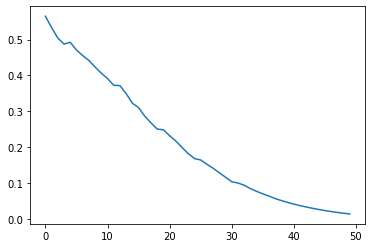

In [13]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(0)
net1 = Net04().cuda()
p = Variable(torch.randn(1,6,3, 112, 336)).cuda()
q = Variable(torch.randn(5,1,2)).cuda()
#print (out.shape)

criterion = nn.MSELoss()
optimizer = optim.SGD(net1.parameters(), lr=0.005)
#optimizer = optim.Adam(net1.parameters(), lr=0.0007,weight_decay=0.01)
#optimizer = optim.Adam(net.parameters(), lr=0.01,betas=(0.9,0.99))
loss_values = []
for i in range (50):
    optimizer.zero_grad()
     
    out = net1(p)

    los = criterion(out, q)
      
    los.backward()
    #print(i,los)
    optimizer.step()
    
    loss_values.append(los.item())
#del p,q,out,los
#torch.cuda.empty_cache()     
plt.plot(loss_values)     
print(loss_values[-1])

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
# create your optimizer
net = Net04().cuda()
criterion = nn.MSELoss()
#optimizer = optim.Adam(net.parameters(), lr=0.0008,weight_decay=0.01)
optimizer = optim.SGD(net.parameters(), lr=0.001)
loss_values = []
test_values = []
for epoch in range(200):  # loop over the dataset multiple times
    
    running_loss = 0.0
    running_test_loss = 0.0
    for i,data in enumerate(dataloader_train,0):
        
        # get the inputs; data is a list of [inputs, labels]
        X_t, y_t = data['X_train'].cuda(),data['y_train'].cuda()
        
        #print(X_t) #torch.Size([10, 5, 3, 224, 224]) torch.Size([10, 1, 2])
        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        for j in range (len(X_t)):
            outputs = net(X_t[j].reshape(1,NUM_FRAMES,3,112,336))
            if j == 0:
                loss = criterion(outputs, y_t[j].reshape(-1,1,2))
                #print(loss)
                
            else:
                loss += criterion(outputs, y_t[j].reshape(-1,1,2))

        loss.backward()
        optimizer.step()       

        # print statistics
        
        running_loss += loss.item()
    loss_values.append(running_loss)
    #print('[epoch%d] running_loss: %.3f,' %(epoch + 1, running_loss))
             
    with torch.no_grad():        
        for i,data in enumerate(dataloader_test,0):
            X_test, y_test = data['X_test'].cuda(),data['y_test'].cuda()
            for j in range (len(X_test)):
                out_test = net(X_test[j].reshape(1,NUM_FRAMES,3,112,336))
                if j ==0:
                    test_loss = criterion(out_test, y_test[j].reshape(-1,1,2))
                else:
                    test_loss += criterion(out_test, y_test[j].reshape(-1,1,2))
                    
            running_test_loss += test_loss.item()

        test_values.append(running_test_loss)
       
    
    print('[epoch%d] running_loss: %.3f, test_loss:%.3f' %(epoch + 1, running_loss, running_test_loss))


print('Finished Training')


[epoch1] running_loss: 144.486, test_loss:16.832
[epoch2] running_loss: 130.061, test_loss:17.629
[epoch3] running_loss: 128.096, test_loss:17.891
[epoch4] running_loss: 127.157, test_loss:18.160
[epoch5] running_loss: 126.302, test_loss:17.559
[epoch6] running_loss: 125.534, test_loss:17.569
[epoch7] running_loss: 124.626, test_loss:17.421
[epoch8] running_loss: 124.092, test_loss:17.324
[epoch9] running_loss: 123.137, test_loss:17.405
[epoch10] running_loss: 122.338, test_loss:17.690
[epoch11] running_loss: 121.729, test_loss:17.570
[epoch12] running_loss: 121.282, test_loss:17.689
[epoch13] running_loss: 120.643, test_loss:17.831
[epoch14] running_loss: 119.695, test_loss:17.836
[epoch15] running_loss: 119.093, test_loss:17.937
[epoch16] running_loss: 118.694, test_loss:17.928
[epoch17] running_loss: 118.244, test_loss:18.077
[epoch18] running_loss: 117.850, test_loss:18.093
[epoch19] running_loss: 118.093, test_loss:18.039
[epoch20] running_loss: 119.656, test_loss:17.768
[epoch21]

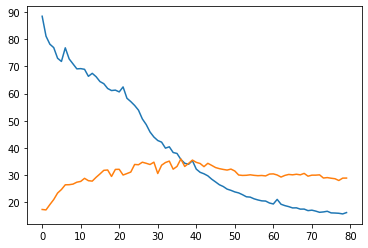

In [38]:
plt.plot(loss_values) 
plt.plot(test_values) 

In [39]:
torch.save(net.state_dict(), 'dataset/data_skill_corner/models/model_303')

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval() 